In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
import joblib
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
train_file = 'train.csv'
test_file = 'test.csv'

In [3]:
df = pd.read_csv(train_file)

# Explore

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info

<bound method DataFrame.info of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                   

PassengerId, Name, Ticket useless

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
for col in df.columns:
    nan_values = df[col].isna().sum()
    print(col, nan_values)

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


Nan values of Age & Embarked to be filled

In [8]:
df['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Too many missing values of cabin; remove too

In [9]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Balancing may be necessary

(array([337., 182., 147.,  50.,  16.,  39.,  18.,  29.,  18.,   2.,   8.,
          7.,   0.,   7.,   9.,   0.,   2.,   0.,   0.,   0.,   4.,   1.,
          4.,   0.,   2.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.]),
 array([  0.      ,  10.246584,  20.493168,  30.739752,  40.986336,
         51.23292 ,  61.479504,  71.726088,  81.972672,  92.219256,
        102.46584 , 112.712424, 122.959008, 133.205592, 143.452176,
        153.69876 , 163.945344, 174.191928, 184.438512, 194.685096,
        204.93168 , 215.178264, 225.424848, 235.671432, 245.918016,
        256.1646  , 266.411184, 276.657768, 286.904352, 297.150936,
        307.39752 , 317.644104, 327.890688, 338.137272, 348.383856,
        358.63044 , 368.877024, 379.123608, 389.370192, 399.616776,
        409.86336 , 420.109944, 430.356528, 440.603112, 450.849696,
        461.09628 , 471.342864, 481.589448, 49

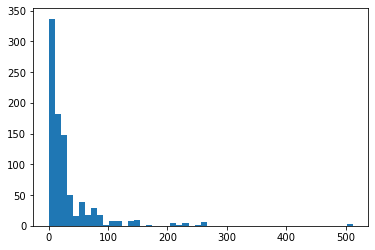

In [10]:
plt.hist(df['Fare'], bins=50)

Remove outlier or use Standardize instead of Normalize

# Create Train and Test-Dataset

In [11]:
def create_datasets(data):
    df = data.copy()
    y = df.pop('Survived')
    X = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = create_datasets(df)

# Preprocess the data using a pipeline

In [13]:
num_attribs = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Sex', 'Embarked']

In [14]:
num_pipeline = Pipeline([
    ('Imputer_Median_Num', SimpleImputer(strategy='median')),
    ('Standardize_Num', StandardScaler())
])

In [15]:
cat_pipeline = Pipeline([
    ('Imputer_Median_Cat', SimpleImputer(strategy='most_frequent')),
    ('OneHot', OneHotEncoder(sparse=False))  # return array not sparse matrix
])

In [16]:
num_cat_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_attribs),
    ('cat_pipeline', cat_pipeline, cat_attribs)
])

In [17]:
type(X_train)

pandas.core.frame.DataFrame

In [18]:
X_train = num_cat_pipeline.fit_transform(X_train)

In [19]:
X_train.shape

(623, 10)

In [20]:
y_train.shape

(623,)

# Try different models and hyperparameters

1) Support Vector Classifier

In [21]:
svc = SVC()

In [22]:
svc_params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1, 2, 3, 4],
    'C': [0.1, 1, 10, 100, 1_000]
}

In [23]:
svc_search = RandomizedSearchCV(svc, svc_params, cv=10, scoring='accuracy', verbose=10)

In [24]:
svc_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ kernel=linear, degree=2, C=1, score=0.714, total=   0.0s
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ kernel=linear, degree=2, C=1, score=0.746, total=   0.0s
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ kernel=linear, degree=2, C=1, score=0.905, total=   0.0s
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ kernel=linear, degree=2, C=1, score=0.855, total=   0.0s
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ kernel=linear, degree=2, C=1, score=0.726, total=   0.0s
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ kernel=linear, degree=2, C=1, score=0.694, total=   0.0s
[CV] kernel=linear, degree=2, C=1 ....................................
[CV] ........ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


[CV] ........ kernel=rbf, degree=2, C=1000, score=0.794, total=   0.1s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] ........ kernel=rbf, degree=2, C=1000, score=0.714, total=   0.0s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] ........ kernel=rbf, degree=2, C=1000, score=0.857, total=   0.1s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] ........ kernel=rbf, degree=2, C=1000, score=0.806, total=   0.1s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] ........ kernel=rbf, degree=2, C=1000, score=0.774, total=   0.0s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] ........ kernel=rbf, degree=2, C=1000, score=0.710, total=   0.0s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] ........ kernel=rbf, degree=2, C=1000, score=0.710, total=   0.0s
[CV] kernel=rbf, degree=2, C=1000 ....................................
[CV] .

[CV] ........ kernel=rbf, degree=1, C=1000, score=0.857, total=   0.1s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] ........ kernel=rbf, degree=1, C=1000, score=0.806, total=   0.1s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] ........ kernel=rbf, degree=1, C=1000, score=0.774, total=   0.0s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] ........ kernel=rbf, degree=1, C=1000, score=0.710, total=   0.0s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] ........ kernel=rbf, degree=1, C=1000, score=0.710, total=   0.0s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] ........ kernel=rbf, degree=1, C=1000, score=0.774, total=   0.1s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] ........ kernel=rbf, degree=1, C=1000, score=0.742, total=   0.1s
[CV] kernel=rbf, degree=1, C=1000 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'degree': [1, 2, 3, 4],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   scoring='accuracy', verbose=10)

In [25]:
svc_search.best_params_

{'kernel': 'rbf', 'degree': 3, 'C': 100}

In [26]:
svc_search.best_score_

0.7927547363031234

In [27]:
svc_params_2 = {
    'kernel': ['rbf'],
    'degree': [2],
    'C': [0.5, 0.75, 1, 1.5, 2, 3, 4, 5]
}

In [28]:
svc_2 = SVC()

In [29]:
svc_search_2 = RandomizedSearchCV(svc_2, svc_params_2, cv=10, scoring='accuracy', verbose=10)

In [30]:
svc_search_2.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... kernel=rbf, degree=2, C=0.5, score=0.794, total=   0.0s
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... kernel=rbf, degree=2, C=0.5, score=0.794, total=   0.0s
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... kernel=rbf, degree=2, C=0.5, score=0.937, total=   0.0s
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... kernel=rbf, degree=2, C=0.5, score=0.871, total=   0.0s
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... kernel=rbf, degree=2, C=0.5, score=0.823, total=   0.0s
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... kernel=rbf, degree=2, C=0.5, score=0.742, total=   0.0s
[CV] kernel=rbf, degree=2, C=0.5 .....................................
[CV] ......... k

/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s rema

[CV] ........... kernel=rbf, degree=2, C=2, score=0.794, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] ........... kernel=rbf, degree=2, C=2, score=0.921, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] ........... kernel=rbf, degree=2, C=2, score=0.887, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] ........... kernel=rbf, degree=2, C=2, score=0.806, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] ........... kernel=rbf, degree=2, C=2, score=0.790, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] ........... kernel=rbf, degree=2, C=2, score=0.839, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] ........... kernel=rbf, degree=2, C=2, score=0.758, total=   0.0s
[CV] kernel=rbf, degree=2, C=2 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.3s finished


RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': [0.5, 0.75, 1, 1.5, 2, 3, 4, 5],
                                        'degree': [2], 'kernel': ['rbf']},
                   scoring='accuracy', verbose=10)

In [31]:
svc_search_2.best_params_

{'kernel': 'rbf', 'degree': 2, 'C': 3}

In [32]:
svc_search_2.best_score_

0.8298515104966718

In [33]:
svc_best = SVC(kernel='rbf', degree=2, C=3)

2) Random Forest Classifier

In [34]:
rfc = RandomForestClassifier(random_state=42)

In [35]:
rfc_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [36]:
rfc_search = RandomizedSearchCV(rfc, rfc_params, cv=10, scoring='accuracy', verbose=10)

In [37]:
rfc_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.778, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.810, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.905, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.919, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.806, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.774, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.790, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.774, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.774, total=   0.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, score=0.903, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, score=0.810, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, score=0.794, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, score=0.794, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, m

[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, score=0.794, total=   0.7s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, score=0.825, total=   0.7s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, score=0.887, total=   0.7s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, score=0.823, total=   0.7s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt,

[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, score=0.839, total=   1.1s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, score=0.839, total=   1.1s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, score=0.726, total=   1.1s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, score=0.823, total=   1.1s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=sqrt,

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='accuracy', verbose=10)

In [38]:
rfc_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

In [39]:
rfc_search.best_score_

0.8330773169482846

In [40]:
rfc_params_2 = {
    'bootstrap': [False],
    'max_depth': [90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5, 7, 10, 20, 50],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [700, 750, 800, 850, 900]
}

In [41]:
rfc_2 = RandomForestClassifier(random_state=42)

In [42]:
rfc_search_2 = RandomizedSearchCV(rfc_2, rfc_params_2, cv=10, scoring='accuracy', verbose=10)

In [43]:
rfc_search_2.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.762, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.794, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.905, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.919, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.806, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.790, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.1s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.790, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.6s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.726, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.774, total=   0.5s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.6s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=90, bootstrap=False, score=0.903, total=   0.5s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=750, min_samples_split=1, min_samples_leaf=5, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.1s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=900, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=90, bootstrap=False, score=0.794, total=   0.5s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=90, bootstrap=False, score=0.810, total=   0.5s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=90, bootstrap=False, score=0.841, total=   0.5s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth

/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False 


/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/joblib/p

[CV]  n_estimators=850, min_samples_split=1, min_samples_leaf=7, max_features=sqrt, max_depth=90, bootstrap=False, score=nan, total=   0.2s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=0.810, total=   0.5s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=0.810, total=   0.5s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=0.905, total=   0.5s
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth

[CV]  n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False, score=0.794, total=   0.4s
[CV] n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False, score=0.921, total=   0.4s
[CV] n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False, score=0.887, total=   0.4s
[CV] n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt, max_depth=90, bootstrap=False, score=0.774, total=   0.4s
[CV] n_estimators=750, min_samples_split=3, min_samples_leaf=20, max_features=sqrt,

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   36.6s finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [False], 'max_depth': [90],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 4, 5, 7, 10, 20,
                                                             50],
                                        'min_samples_split': [1, 2, 3],
                                        'n_estimators': [700, 750, 800, 850,
                                                         900]},
                   scoring='accuracy', verbose=10)

In [44]:
rfc_search_2.best_params_

{'n_estimators': 800,
 'min_samples_split': 3,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [45]:
rfc_search_2.best_score_

0.833026113671275

In [46]:
rfc_best = RandomForestClassifier(bootstrap=False, n_estimators=850, min_samples_split=3, min_samples_leaf=3,
                                  max_features='sqrt', max_depth=90)

3) Gradient Boosting Classifier

In [47]:
gbc = GradientBoostingClassifier()

In [48]:
gbc_params = {
    'n_estimators': [200, 600, 1000, 1400, 1800, 2500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 50, 90, 150]
}

In [49]:
gbc_search = RandomizedSearchCV(gbc, gbc_params, cv=10, scoring='accuracy', verbose=10)

In [50]:
gbc_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.746, total=   2.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.794, total=   2.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.762, total=   2.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.887, total=   2.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.5s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.806, total=   2.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.677, total=   2.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.8s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.774, total=   2.8s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   18.6s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.774, total=   2.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   21.3s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.742, total=   2.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   23.9s remaining:    0.0s


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, score=0.823, total=   2.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150, score=0.778, total=   0.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150, score=0.778, total=   0.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150, score=0.746, total=   0.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=150, score

[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, score=0.790, total=   2.0s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, score=0.806, total=   2.0s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, score=0.758, total=   2.0s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, score=0.806, total=   2.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, score=0

[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, score=0.806, total=   0.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, score=0.823, total=   0.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, score=0.677, total=   0.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, score=0.790, total=   0.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, score=0.806, t

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': [10, 50, 90, 150],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 600, 1000, 1400,
                                                         1800, 2500]},
                   scoring='accuracy', verbose=10)

In [51]:
gbc_search.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 150}

In [52]:
gbc_search.best_score_

0.8042498719918074

In [53]:
gbc_2 = GradientBoostingClassifier()

In [54]:
gbc_params_2 = {
    'n_estimators': [1600, 1700, 1800, 1900, 2000, 2100],
    'min_samples_split': [1, 2, 3, 4],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto'],
    'max_depth': [2, 5, 10, 15, 20]
}

In [55]:
gbc_search_2 = RandomizedSearchCV(gbc_2, gbc_params_2, cv=10, scoring='accuracy', verbose=10)

In [56]:
gbc_search_2.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.762, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.762, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.778, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.855, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.0s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.806, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.742, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.0s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.806, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.6s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.790, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.1s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.806, total=   2.5s
[CV] n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.6s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=4, min_samples_leaf=3, max_features=auto, max_depth=10, score=0.823, total=   2.6s
[CV] n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15 
[CV]  n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15, score=nan, total=   0.0s
[CV] n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15 
[CV]  n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15, score=nan, total=   0.0s
[CV] n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15 
[CV]  n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15, score=nan, total=   0.0s
[CV] n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15 
[CV]  n_estimators=2100, min_samples_split=1, min_samples_leaf=3, max_features=auto, max_depth=15, score=nan, 

/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/home/olli/anaconda3/envs/ubiquant/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted)
  File "/home/olli/anac

[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.762, total=   3.1s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.762, total=   3.0s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.778, total=   3.2s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.871, total=   3.2s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score

[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, score=0.774, total=   3.8s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, score=0.790, total=   3.8s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, score=0.806, total=   3.9s
[CV] n_estimators=2000, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=2000, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.778, total=   3.9s
[CV] n_estimators=2000, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=2000, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=20, score

[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.839, total=   3.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.726, total=   3.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.774, total=   3.7s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score=0.790, total=   3.6s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=20, score

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.2min finished


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': [2, 5, 10, 15, 20],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3],
                                        'min_samples_split': [1, 2, 3, 4],
                                        'n_estimators': [1600, 1700, 1800, 1900,
                                                         2000, 2100]},
                   scoring='accuracy', verbose=10)

In [57]:
gbc_search_2.best_params_

{'n_estimators': 1600,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 20}

In [58]:
gbc_search_2.best_score_

0.8026625704045058

In [59]:
gbc_best = GradientBoostingClassifier(n_estimators=1600, min_samples_split=4, min_samples_leaf=2,
                                      max_features='auto', max_depth=15)

Building a pipeline with the models

In [60]:
full_svc = Pipeline([
    ('preprocess_pipeline', num_cat_pipeline),
    ('SVC', svc_best)
])

In [61]:
full_rfc = Pipeline([
    ('preprocess_pipeline', num_cat_pipeline),
    ('RFC', rfc_best)
])

In [62]:
full_gbc = Pipeline([
    ('preprocess_pipeline', num_cat_pipeline),
    ('GBC', gbc_best)
])

In [63]:
#needs dataframe as input not numpy array
X_train, X_test, y_train, y_test = create_datasets(df)

In [64]:
full_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('Imputer_Median_Num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Standardize_Num',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('Imputer_Median_Cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHot',
                                         

In [65]:
full_rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('Imputer_Median_Num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Standardize_Num',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('Imputer_Median_Cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHot',
                                         

In [66]:
full_gbc.fit(X_train, y_train)

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('Imputer_Median_Num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Standardize_Num',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('Imputer_Median_Cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHot',
                                         

In [67]:
ensemble_svc_rfc = VotingClassifier(
    estimators=[('svc', full_svc), ('rfc', full_rfc)] )

In [68]:
ensemble_svc_rfc.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('preprocess_pipeline',
                                               ColumnTransformer(transformers=[('num_pipeline',
                                                                                Pipeline(steps=[('Imputer_Median_Num',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('Standardize_Num',
                                                                                                 StandardScaler())]),
                                                                                ['Pclass',
                                                                                 'Age',
                                                                                 'SibSp',
                                           

In [69]:
ensemble_svc_rfc_gbc = VotingClassifier(
    estimators=[('svc', full_svc), ('rfc', full_rfc), ('gbc', full_gbc)],
    weights=[2, 2, 1])  # gbc performs worse

In [70]:
ensemble_svc_rfc_gbc.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('preprocess_pipeline',
                                               ColumnTransformer(transformers=[('num_pipeline',
                                                                                Pipeline(steps=[('Imputer_Median_Num',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('Standardize_Num',
                                                                                                 StandardScaler())]),
                                                                                ['Pclass',
                                                                                 'Age',
                                                                                 'SibSp',
                                           

# Evaluation

In [71]:
y_test_array = np.array(y_test)

In [72]:
full_svc_score = accuracy_score(y_test_array, full_svc.predict(X_test))
full_svc_score

0.8171641791044776

In [73]:
full_rfc_score = accuracy_score(y_test_array, full_rfc.predict(X_test))
full_rfc_score

0.8059701492537313

In [74]:
full_gbc_score = accuracy_score(y_test_array, full_gbc.predict(X_test))
full_gbc_score

0.7686567164179104

In [75]:
ensemble_svc_rfc_score = accuracy_score(y_test_array, ensemble_svc_rfc.predict(X_test))
ensemble_svc_rfc_score

0.8097014925373134

In [76]:
ensemble_svc_rfc_gbc = accuracy_score(y_test_array, ensemble_svc_rfc_gbc.predict(X_test))
ensemble_svc_rfc_gbc

0.832089552238806

Surprisingly the last ensemble with all 3 models performs by far the best

# Fit with full data, save model and make prediction on testfile

In [77]:
final_model = VotingClassifier(
    estimators=[('svc', full_svc), ('rfc', full_rfc), ('gbc', full_gbc)],
    weights=[2, 2, 1])

In [78]:
def create_final_data(data):
    df = data.copy()
    y = df.pop('Survived')
    X = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    return X, y

In [79]:
X, y = create_final_data(data=df)

In [80]:
final_model.fit(X, y)

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('preprocess_pipeline',
                                               ColumnTransformer(transformers=[('num_pipeline',
                                                                                Pipeline(steps=[('Imputer_Median_Num',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('Standardize_Num',
                                                                                                 StandardScaler())]),
                                                                                ['Pclass',
                                                                                 'Age',
                                                                                 'SibSp',
                                           

In [81]:
joblib.dump(final_model, 'Ensemble_SVC_RFC_GBC.joblib')

['Ensemble_SVC_RFC_GBC.joblib']

In [82]:
test_df = pd.read_csv(test_file)

In [83]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [84]:
PassengerId = test_df.pop('PassengerId')  # needed for submission

In [85]:
test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [86]:
test_df.head(1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q


In [87]:
prediction_test = final_model.predict(test_df)

In [88]:
prediction_test

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [89]:
prediction = pd.DataFrame(prediction_test, columns=['Survived'])

In [90]:
prediction.head(3)

,Survived
0,0
1,0
2,0


In [91]:
prediction['PassengerId'] = PassengerId

In [92]:
prediction.head(3)

,Survived,PassengerId
0,0,892
1,0,893
2,0,894


In [93]:
prediction_titels = ['PassengerId', 'Survived']

In [94]:
prediction = prediction.reindex(columns=prediction_titels)

In [95]:
prediction.head(3)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0


In [97]:
prediction.to_csv('Titanic_Pred_Ensemble_SVC_RFC_GBC.csv', index=False)

In [98]:
test_df.shape

(418, 8)